# WAE-GAN model

In [38]:
from model.exp1.train_wae_gan import WAE_GAN_MNIST as MODEL1
from model.exp2.train_wae_gan import WAE_GAN_MNIST as MODEL2

In [13]:
import os, sys, time, logging, configparser
# sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
# os.environ['CUDA_VISIBLE_DEVICES']='7'
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus, multinomial
from XAE.logging_daily import logging_daily
import XAE.fid as fid

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_wae_gan1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_wae_gan2.cfg')

test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_data2 = MNIST(cfg['path_info']['data_home'], train = False, label = False, output_channels = 3)

## Load WAE-GAN model

In [40]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [41]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [10]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = model1(test_sample_image.to(device)).to('cpu').detach().numpy()

In [11]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

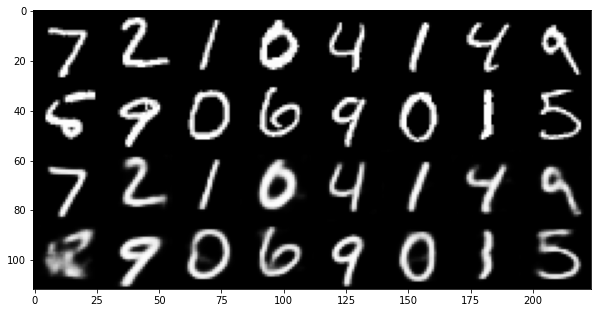

In [12]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

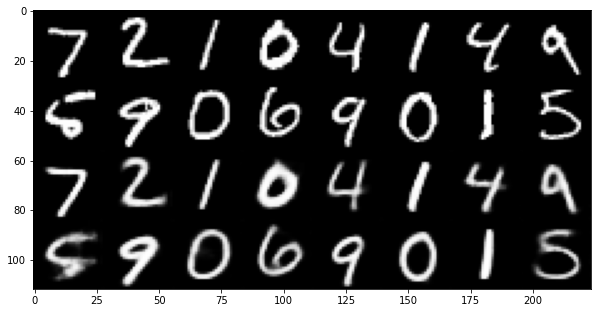

In [42]:
recon_sample = model2(test_sample_image.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [35]:
z = gaus(60, 8)
Z = z.to(device)

In [51]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz1, gz2 = [], []
for i in range(6):
    gz1.append(np.concatenate([gen_sample1[10*i + j,0,:,:] for j in range(10)], axis = 1))
    gz2.append(np.concatenate([gen_sample2[10*i + j,0,:,:] for j in range(10)], axis = 1))
generation_result1 = np.concatenate(gz1, axis = 0) # concatenate matrix for plt
generation_result2 = np.concatenate(gz2, axis = 0) # concatenate matrix for plt

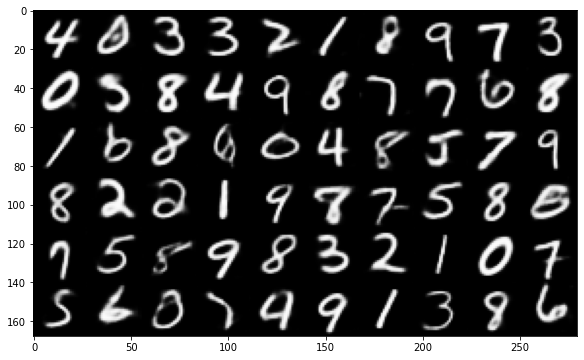

In [52]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result1, cmap='gray', vmin=-1, vmax=1)
plt.show()

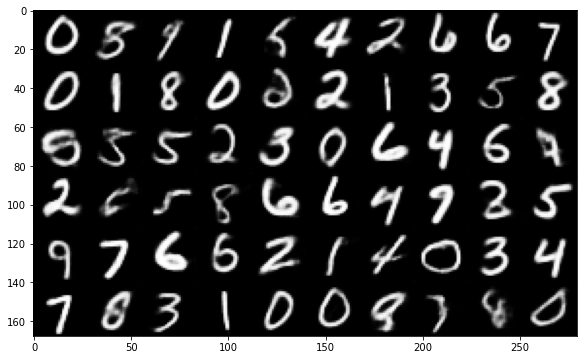

In [53]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result2, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Sharpness and FID

In [58]:
ss = calculate_sharpness(test_data2, device = device)
ss.mean()

0.7309414733842016

In [59]:
fid_model = fid.InceptionV3().to(device)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/zendo/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


In [64]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


In [60]:
z_sampler = lambda x: gaus(x, 8).to(device)

In [62]:
act1 = fid.get_activations_generator(model1.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [65]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

28.128512438862515

In [67]:
act2 = fid.get_activations_generator(model2.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [68]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

26.75132829014305

# CWAE-GAN model

In [69]:
from model.exp1.train_cwae_gan import CWAE_GAN_MNIST as MODEL1
from model.exp2.train_cwae_gan import CWAE_GAN_MNIST as MODEL2

In [70]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_cwae_gan1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_cwae_gan2.cfg')

['./config/train_config_cwae_gan2.cfg']

## Load CWAE-GAN model

In [71]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [72]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [74]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = model1(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()

In [75]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

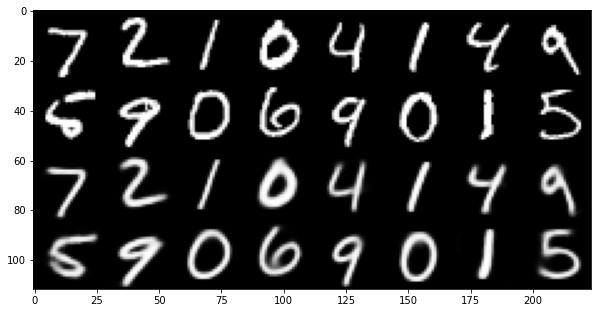

In [76]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

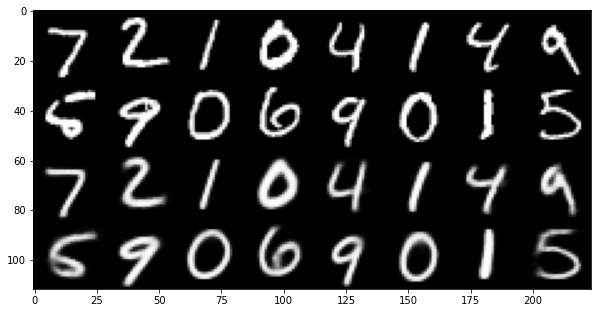

In [77]:
recon_sample = model2(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [98]:
test_z = []
test_label = []
z = gaus(6, 6)

for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)
Z.shape

torch.Size([60, 16])

In [99]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz1, gz2 = [], []
for i in range(10):
    gz1.append(np.concatenate([gen_sample1[6*i + j,0,:,:] for j in range(6)], axis = 1))
    gz2.append(np.concatenate([gen_sample2[6*i + j,0,:,:] for j in range(6)], axis = 1))
generation_result1 = np.concatenate(gz1, axis = 0) # concatenate matrix for plt
generation_result2 = np.concatenate(gz2, axis = 0) # concatenate matrix for plt

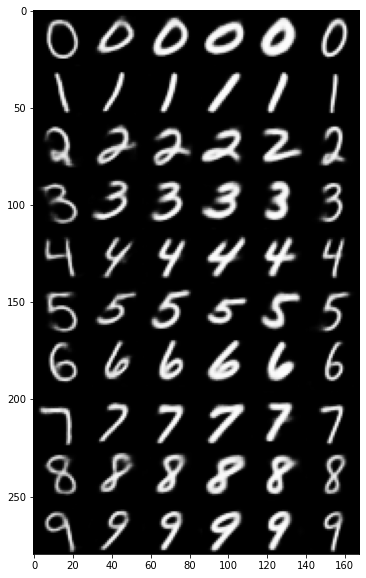

In [102]:
plt.figure(figsize = (6, 10))
plt.imshow(generation_result1, cmap='gray', vmin=-1, vmax=1)
plt.show()

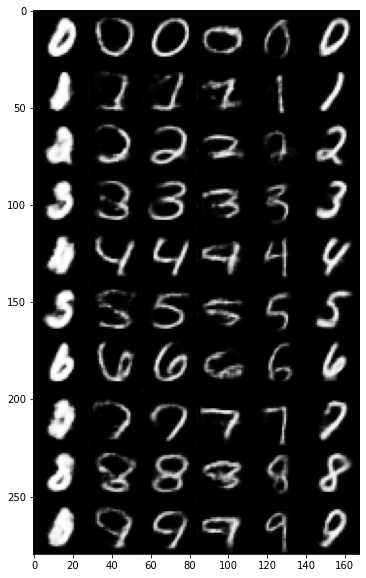

In [103]:
plt.figure(figsize = (6,10))
plt.imshow(generation_result2, cmap='gray', vmin=-1, vmax=1)
plt.show()